In [1]:
import pandas as pd
import re
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline

0. Define functions to convert the coordinates into degree-minute-seconds

In [2]:
def parse_latlon(s):
    ''' Parse a string s which contains either a longitude or a latitude and convert it into Degree Minute Second vector'''
    
    if len(s.split('°')) >1:
        deg = s.split('°')[0]
        rest = s.split('°')[1].strip()
        if len(rest.split("''"))>1:
            rest = rest.split("''")[0].split("'")
            minute = rest[0]
            sec = rest[1]
            return [deg,minute,sec]
        elif len(rest.split('"'))>1:
            rest = rest.split('"')[0].split("'")
            minute = rest[0]
            sec = rest[1]
            return [float(deg),float(minute),float(sec)]
        elif len(rest.split("'"))>1:
            minute = rest.split("'")[0]
            return [float(deg),float(minute),None]
        elif len(rest) == 0:
            return [float(deg),None,None]


def dms_to_dd(data):
    ''' Converts Degree Minute Second vector into Decimal Degrees coordinates'''
    
    return pd.Series(np.nansum([data['degrees'],np.sign(data['degrees'])*data['minutes']/60.,np.sign(data['degrees'])*data['seconds']/3600],axis=0),index=['lat','lon'])

def convert(s):
    ''' Convert a coordinate string s into a pandas Series of latitude and longitude in Decimal Degrees format'''
    try:
        pat = "^,*\s*"
        p = re.compile(pat)
        if len(s.split('N'))>1:
            latstr = s.split('N')[0]
            lonstr = re.sub(p,'',s.split('N')[1])
        elif len(s.split('S'))>1:
            latstr = s.split('S')[0]
            lonstr = re.sub(p,'',s.split('S')[1])
            latstr = '-'+latstr
        else:
             return None   
        if lonstr.find('W') != -1:
            lonstr = '-'+lonstr
        lonstr = lonstr.split('E')[0]
        lonstr = lonstr.split('W')[0]

        lat = np.array(parse_latlon(latstr))
        lon = np.array(parse_latlon(lonstr))
        res = dms_to_dd(pd.DataFrame([lat,lon],columns=['degrees','minutes','seconds']).astype(float))
    except Exception as e:
        res = 'error'
        return pd.Series([res,res],index=['lat','lon'])
    return res

1. Load raw data, merge synthetic coordinates and mark seperately the synthetic coordiantes and the region level coordinates

In [3]:
data = pd.read_excel('data/RawData.xlsx') #Read
data.loc[~data['synthetic coordinates'].isna(),'coordinates'] = data.loc[~data['synthetic coordinates'].isna(),'synthetic coordinates'] #Merge
data.loc[~data['synthetic coordinates'].isna(),'synthetic'] = True #Mark sythetic
region_data = data['remarks'].str.contains('region|Country').dropna() #find region-level or country-level locations
data.loc[region_data[region_data].index,'region'] = True #mark region data

/Users/Yuvalr/opt/anaconda3/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:296: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [4]:
data.loc[data['sub-class']=='Acari','aggregated taxon'] = 'Acari'
data.loc[data['sub-class']=='Collembola','aggregated taxon'] = 'Collembola'
data.loc[data['super-family']=='Isoptera','aggregated taxon'] = 'Isoptera'
data.loc[data['family']=='Formicidae','aggregated taxon'] = 'Formicidae'
data.loc[data['aggregated taxon'].isna(),'aggregated taxon'] = 'Other'

In [5]:
#extract habitats (env) and combine canopies into above-ground
env = data['aggregated environment'].unique()
data.loc[data['aggregated environment']=='canopy','aggregated environment'] = 'above ground'

2. Find unique site-coordinate combinations 

In [6]:
#site_locations = data.loc[:,['site','coordinates']].drop_duplicates()
site_locations = data.loc[:,['site','coordinates','aggregated environment','aggregated taxon']].drop_duplicates()
site_with_coords = site_locations[(~site_locations.coordinates.isna()) & (site_locations.coordinates != 0)]
site_with_coords = site_with_coords.merge(data.loc[~data['synthetic coordinates'].isna(),['synthetic','region']],left_index=True,right_index=True,how='left')

In [7]:
print('all sites with valid location, repeated for the various taxa: %d' % site_with_coords.loc[:,['site','coordinates']].shape[0])
print('unique sites-location pairs: %d' % site_with_coords.loc[:,['site','coordinates']].drop_duplicates().shape[0])
print('unique sites: %d' % site_with_coords.loc[:,['site','coordinates']].site.nunique())
print('unique coordinates: %d' % site_with_coords.loc[:,['site','coordinates']].coordinates.nunique())

all sites with valid location, repeated for the various taxa: 880
unique sites-location pairs: 483
unique sites: 471
unique coordinates: 282


In [19]:
print('Total number of sites in soil is %d' % site_with_coords.loc[data['aggregated environment']== 'soil/litter'].site.nunique())
print('Total number of sites above ground is %d' % site_with_coords.loc[data['aggregated environment']== 'above ground'].site.nunique())

Total number of sites in soil is 421
Total number of sites above ground is 54


3. Convert string coordinates into latitudes and longitudes

In [10]:
site_with_coords[['lat','lon']] = site_with_coords.loc[:,'coordinates'].apply(convert)

4. Mark each coordinate type in a different color

In [9]:
site_with_coords = site_with_coords[site_with_coords.lon!='error']

acc_coords = site_with_coords.loc[site_with_coords.synthetic.isna()]
syn_coords = site_with_coords.loc[(~site_with_coords.synthetic.isna()) & (site_with_coords.region.isna())]
region_coords = site_with_coords.loc[~site_with_coords.region.isna()]

In [10]:
#function to filter out a specific environment (habitat type)
def filt_env(x,env_name):
    return x[x['aggregated environment']==env_name]

def plt_scat(coords,env,Label,Col,Marker,Size):
    plt.scatter(filt_env(coords,env).lon.values, filt_env(coords,env).lat.values,
    marker=Marker, s=Size,color = Col,#facecolors=Col, edgecolors='w',linewidths=0.001, #color = Col,
    transform=ccrs.Geodetic(),label = Label)  
    
def plt_scat2(coords,env,Label,Col_in, Col_out,Marker,Size):
    plt.scatter(filt_env(coords,env).lon.values, filt_env(coords,env).lat.values,
    marker=Marker, s=Size,facecolors=Col_in, edgecolors=Col_out,linewidths=0.4, ##6F44FF'
    transform=ccrs.Geodetic(),label = Label)  

5. Plot results

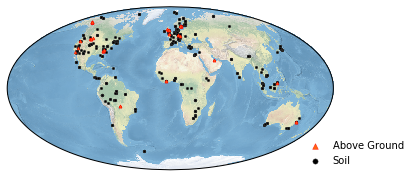

In [16]:
marker_style = dict(color='k', marker='o',
                    markersize=4, markerfacecoloralt='tab:red')

fig = plt.figure(figsize=(6,3))
ax = plt.axes(projection=ccrs.Mollweide())
ax.stock_img()

plt_scat2(site_with_coords,env[0],Label='Soil' ,Col_in='k',Col_out ='#424242',Marker='o',Size=7)
plt_scat2(site_with_coords,env[1],Label='Above Ground',Col_in='#ff6512',Col_out ='red',Marker='^',Size=8)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]#range(2)
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=(0.9,0),frameon=False,markerscale=2)
#plt.tight_layout()

#plt.savefig('results/figs/png/locations_fig_all.png',dpi=600,bbox_inches = "tight")
plt.savefig('results/figs/locations and times/locations_fig_all.pdf',dpi=600,bbox_inches = "tight")


plt.show()


6. Repeat for every aggregated taxon

In [18]:
soil_site_with_coords = site_with_coords[site_with_coords['aggregated environment']=='soil/litter']

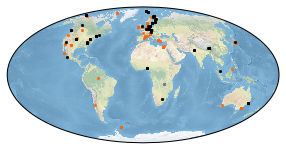

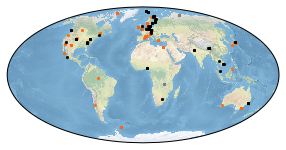

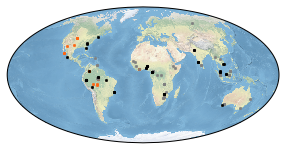

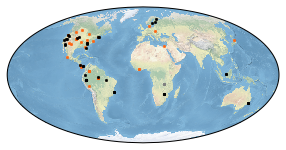

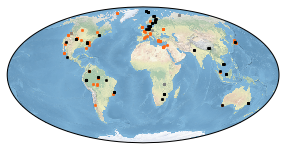

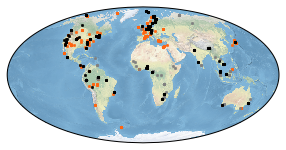

In [20]:
#plotting the various soil taxa, according to the various accuracy of location
def PlotScatt(x,Title):
    
    
    acc_coords = x.loc[x.synthetic.isna()]
    syn_coords = x.loc[(~site_with_coords.synthetic.isna()) & (site_with_coords.region.isna())]
    region_coords = x.loc[~x.region.isna()]
    
    fig = plt.figure(figsize=(5,2.5))
    ax = plt.axes(projection=ccrs.Mollweide())
    ax.stock_img()

    plt.scatter(syn_coords.lon.values, syn_coords.lat.values,
        marker='o', s=7,color='#FF6511',linewidths=0.4,
         transform=ccrs.Geodetic(),label = 'Approximate Coordinates'
         )

    plt.scatter(region_coords.lon.values, region_coords.lat.values,
         marker='o', s=7,color='#808080',linewidths=0.4,
         transform=ccrs.Geodetic(),label = 'Region-Level Coordinates'
         )

    plt.scatter(acc_coords.lon.values, acc_coords.lat.values,
         marker='o', s=7,color='k', linewidths=0.4,
         transform=ccrs.Geodetic(),label = 'Accurate Coordinates'
         )

#    handles, labels = plt.gca().get_legend_handles_labels()
#    order = [2,0,1]
#    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=(1.01,0),title=Title,title_fontsize = 'large',frameon=False)
        
    return fig

def plotS_N_save(ag_taxon, title):
    if ag_taxon=='All':
        x = soil_site_with_coords
    else:
        x = soil_site_with_coords.loc[soil_site_with_coords['aggregated taxon']==ag_taxon]
    PlotScatt(x,title)
    filename = 'results/figs/locations and times/locations_fig_accuracy' + title
    plt.savefig(filename + '.pdf',dpi=600,bbox_inches = "tight")
    plt.show()##
    


plotS_N_save('Acari', 'Mites')
plotS_N_save('Collembola', 'Springtails')
plotS_N_save('Isoptera', 'Termites')
plotS_N_save('Formicidae', 'Ants')
plotS_N_save('Other', 'Others')
plotS_N_save('All', 'All Soil Arthropods')



In [19]:
#plotting the various soil taxa, according to the various accuracy of location
def PlotScatt(x,Title):
    
    
    acc_coords = x.loc[x.synthetic.isna()]
    syn_coords = x.loc[(~site_with_coords.synthetic.isna()) & (site_with_coords.region.isna())]
    region_coords = x.loc[~x.region.isna()]    

    plt.scatter(syn_coords.lon.values, syn_coords.lat.values,
        marker='o', s=7,color='#FF6511',linewidths=0.4,
         transform=ccrs.Geodetic(),label = 'Approximate Coordinates'
         )

    plt.scatter(region_coords.lon.values, region_coords.lat.values,
         marker='o', s=7,color='#808080',linewidths=0.4,
         transform=ccrs.Geodetic(),label = 'Region-Level Coordinates'
         )

    plt.scatter(acc_coords.lon.values, acc_coords.lat.values,
         marker='o', s=7,color='k', linewidths=0.4,
         transform=ccrs.Geodetic(),label = 'Accurate Coordinates'
         )        
    return fig


fig, axs = plt.subplots(2,3,figsize=(15,5))

for ax in axs:
    ax = plt.axes(projection=ccrs.Mollweide())
    ax.stock_img()

ax = plt.subplot(2,3,1)
PlotScatt(soil_site_with_coords,'Title')



/Users/Yuvalr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


ValueError: Axes should be an instance of GeoAxes, got <class 'matplotlib.axes._subplots.AxesSubplot'>

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x12b04db00> (for post_execute):


ValueError: Axes should be an instance of GeoAxes, got <class 'matplotlib.axes._subplots.AxesSubplot'>

ValueError: Axes should be an instance of GeoAxes, got <class 'matplotlib.axes._subplots.AxesSubplot'>

<Figure size 1080x360 with 1 Axes>

7. Count number of distinct locations and sites

In [11]:
print('Total number of locations is %d' % site_with_coords[['lat','lon']].drop_duplicates().shape[0])
print('Total number of sites is %d' % data.site.nunique())

print('Total number of sites in soil is %d' % data.loc[data['aggregated environment']== 'soil/litter'].site.nunique())
print('Total number of sites above ground is %d' % data.loc[data['aggregated environment']== 'above ground'].site.nunique())

Total number of locations is 269
Total number of sites is 494
Total number of sites in soil is 444
Total number of sites above ground is 54
